In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

# Overview and Visualize Time series

In [2]:
from datetime import datetime
dateparse = lambda dates : datetime.strptime(dates, '%Y-%m-%d')

data = pd.read_csv('daily-min-temperatures.csv', index_col=0, parse_dates=['Date'], date_parser=dateparse)
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
data.tail()

,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [4]:
data.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


Data là nhiệt độ tối thiểu hằng ngày 10 năm (1981-1990) ở Melbourne, Australia.<br>
Nhiệt độ thấp nhất trong 10 năm là 0&deg;C, cao nhất là 26.3&deg;C<br>
Các giá trị Q1, Q2, Q3 cho thấy một dạng phân phối chuẩn của nhiệt độ min<br>
Dường như năm nhuận đã được xử lý từ trước vì chỉ có đúng 3650 quan sát trong 10 năm<br>

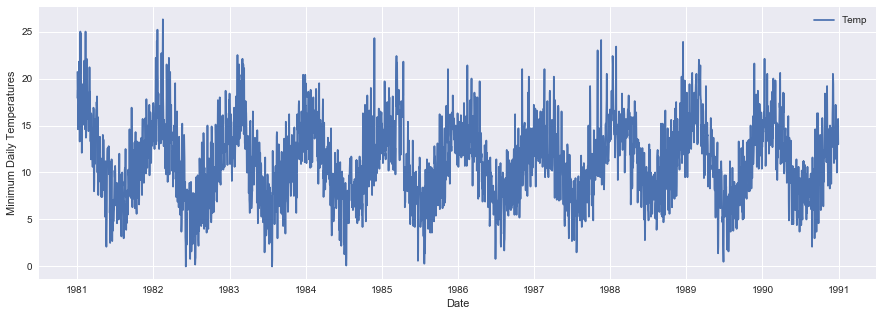

In [5]:
plt.figure(figsize=[15,5])

plt.plot(data, label='Temp')
plt.legend(loc=2)
plt.xlabel('Date')
plt.ylabel('Minimum Daily Temperatures')
plt.legend(loc='best')
plt.show()

>- Mùa Đông ở Melbourne, Australia nằm vào khoảng tháng 6 đến tháng 9 trong năm, mùa hè từ tháng 11 đến tháng 2 năm sau <br>
>- Không có các giá trị oulier trong Time series này. <br>
>- Có thể nhận thấy ngay rằng nó có season rất rõ ràng theo từng năm. Phù hợp với dữ liệu nhiệt độ ứng với thời tiết khí hậu của một khu vực theo từng năm.
>- Trend trên của TS cũng không rõ ràng, dường như không có xu hướng thay đổi nhiệt độ trên tổng thể 10 năm

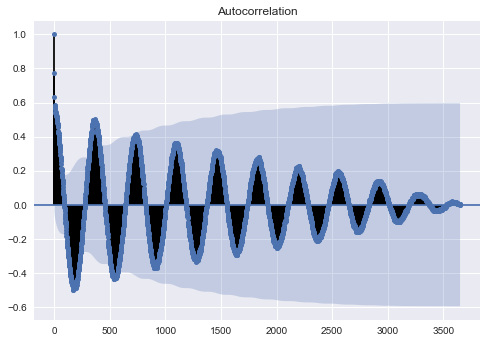

In [6]:
plot_acf(data['Temp'], fft=False, lags=len(data)-1)
plt.show()

>- Đồ thị ACF càng chứng minh thêm rằng đây ko phải là 1 stationary TS <br>
>- ACF giảm đều theo thời gian và dao động dạng sin nhưng tốc độ giảm là rất chậm

***
<h3>Ta sẽ xây dựng mô hình với đầy đủ Trend, Season và Error:<h3> <br>
<center> $Y_{t}=f(Trend_{t}, Seasonality_{t}, Error_{t})$ </center>

## Trend & Seasonality

Thử làm mịn Time series bằng cách sử dụng Moving Average (MA). 

MA sẽ được thử với các khoảng thời gian khác nhau, tức là 1 tháng, 3 tháng, nửa năm và 1 năm

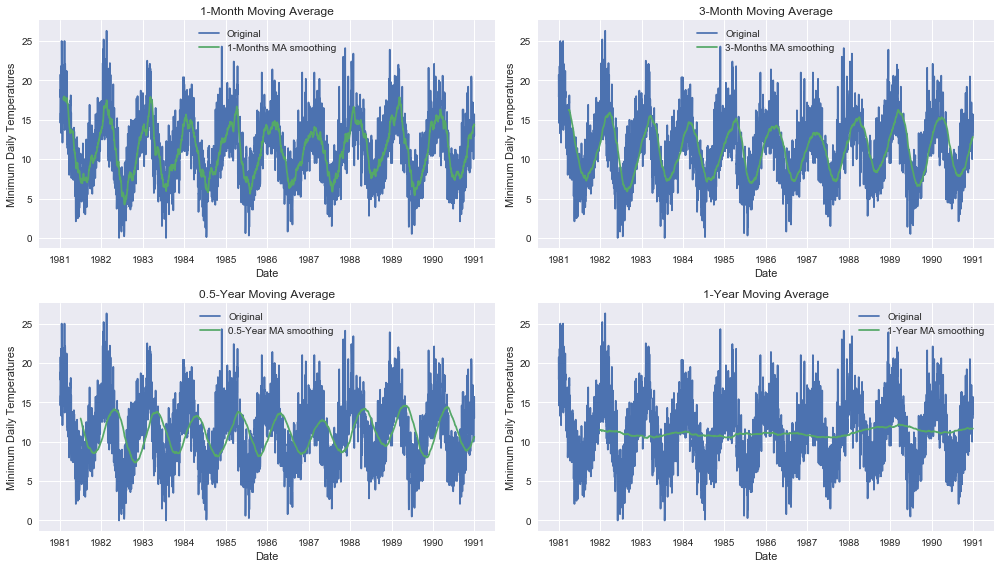

In [7]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(data.index, data['Temp'], label='Original')
axes[0][0].plot(data.index, data['Temp'].rolling(window=30).mean(), label='1-Months MA smoothing')
axes[0][0].set_xlabel("Date")
axes[0][0].set_ylabel("Minimum Daily Temperatures")
axes[0][0].set_title("1-Month Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(data.index, data['Temp'], label='Original')
axes[0][1].plot(data.index, data['Temp'].rolling(window=90).mean(), label='3-Months MA smoothing')
axes[0][1].set_xlabel("Date")
axes[0][1].set_ylabel("Minimum Daily Temperatures")
axes[0][1].set_title("3-Month Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(data.index, data['Temp'], label='Original')
axes[1][0].plot(data.index, data['Temp'].rolling(window=182).mean(), label='0.5-Year MA smoothing')
axes[1][0].set_xlabel("Date")
axes[1][0].set_ylabel("Minimum Daily Temperatures")
axes[1][0].set_title("0.5-Year Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(data.index, data['Temp'], label='Original')
axes[1][1].plot(data.index, data['Temp'].rolling(window=365).mean(), label='1-Year MA smoothing')
axes[1][1].set_xlabel("Date")
axes[1][1].set_ylabel("Minimum Daily Temperatures")
axes[1][1].set_title("1-Year Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

Kết quả cho thấy MA với dữ liệu 365 ngày (1 năm) loại bỏ được là bộ phần dao động sin, cho thấy được Trend của TS

**Quan sát cụ thể và chi tiết hơn đối với 365-day (1-year) moving average:**

In [8]:
MA_mean = data['Temp'].rolling(window=365).mean()
MA_std = data['Temp'].rolling(window=365).std()

mean_arr = np.full(len(data['Temp']), data['Temp'].mean())
Mean_all_obs = pd.DataFrame(data=mean_arr, index=data.index)
mean_arr[0]

11.177753424657539

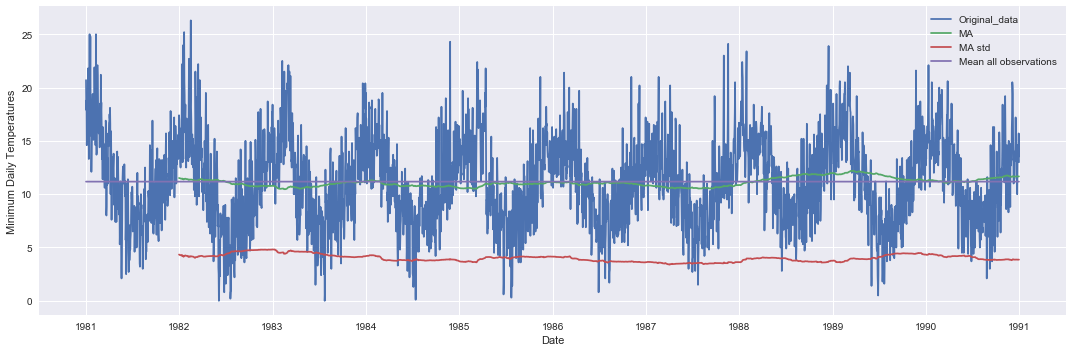

In [9]:
plt.figure(figsize=[15,5])

plt.plot(data['Temp'], label='Original_data')
plt.plot(MA_mean, label='MA')
plt.plot(MA_std, label='MA std')
plt.plot(Mean_all_obs, label='Mean all observations')

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Minimum Daily Temperatures')

plt.tight_layout()
plt.show()

Dựa trên plot có thể thấy là không có trend trên TS này<br>
Đường MA dao dộng nhẹ xung quanh giá trị trung bình toàn dữ liệu.<br>
Độ lệch chuẩn giá trị nhỏ (4) và cũng không biến động quá nhiều.

## Errors

Để mô hình Time series nhiệt độ nhỏ nhất trong ngày ở Melbourne, Australia, Ta sẽ sử dụng mô hình cộng tính như sau: <br>
<center> $Y_{t} = Trend_{t} + Seasonality_{t} + Error_{t}$ </center>

Mô hình nhân tính không được sử dụng vì TS chứa giá trị âm và 0, muốn sử dụng thì cần transform data.

Sử dụng Diffirencing để Loại bỏ Trend và Seasonality

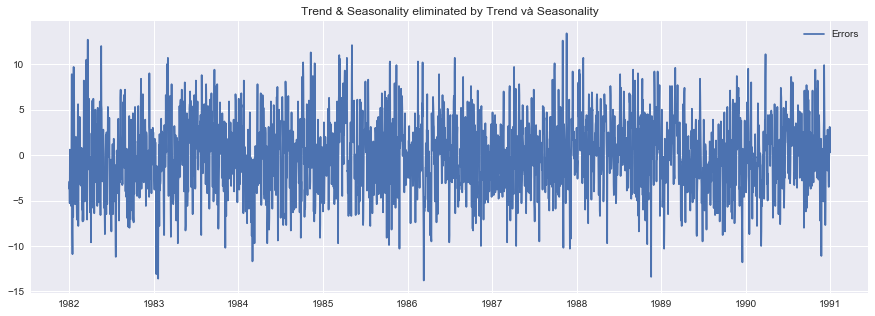

In [10]:
X = data['Temp']
differenced = X.diff(365)

plt.figure(figsize=[15,5])
plt.grid(True)
plt.plot(differenced, label='Errors')
plt.legend(loc='best')
plt.title('Trend & Seasonality eliminated by Trend và Seasonality')
plt.show()

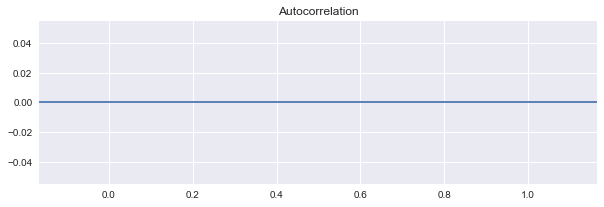

In [11]:
fig = plot_acf(differenced, fft=False)
fig.set_figwidth(10)
fig.set_figheight(3)
plt.show()

Ta thấy ACF của phần errors còn lại là rất nhỏ gần như bằng không ở tất cả các lag<br>
>- Errors này chính là stationary

---
Thử thực hiện bằng thư viện seasonal_decompose 

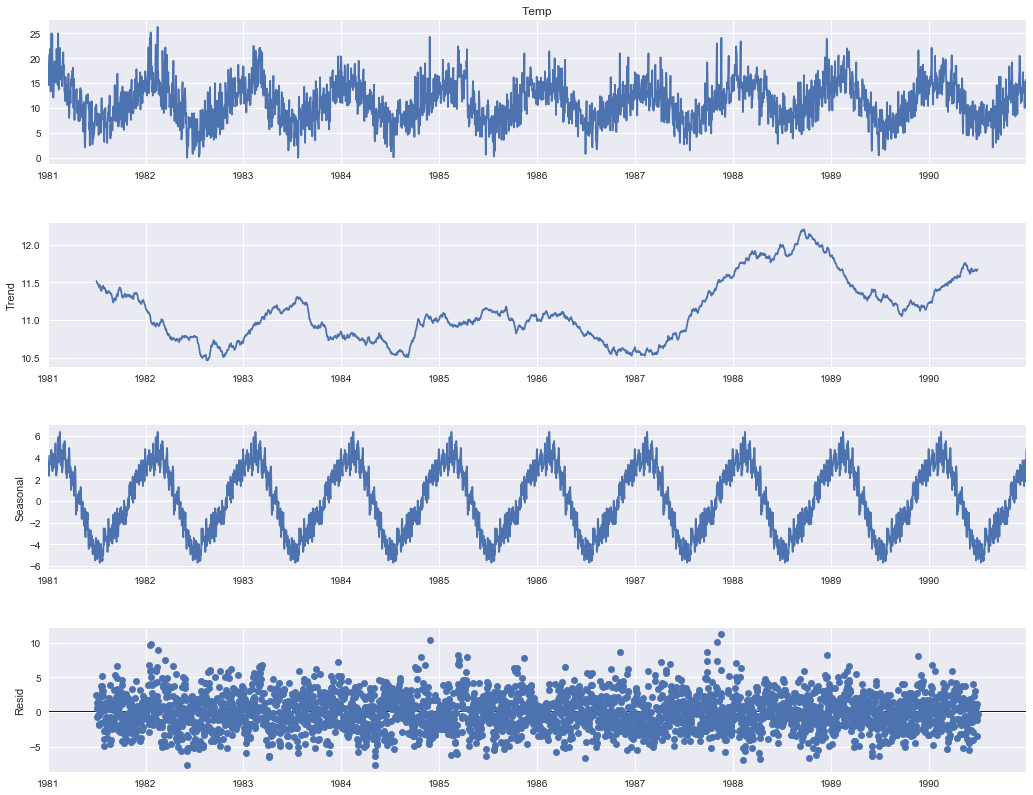

In [12]:
decomp_add = sm.tsa.seasonal_decompose(data['Temp'], model="additive", period=365)
#decomp_add_data.plot()
plt.show()

fig = decomp_add.plot()
fig.set_figwidth(15)
fig.set_figheight(12)
plt.show()

Dựa vào plot ta có nhận xét:
>- Trend: gần như là đường ngang với dao động nhiệt độ từ 10.5&deg;C đế 12.2&deg;C nhưng đa số giá trị đi gần 11&deg;C
>- Seasonality: rất rõ ràng và thống nhất mùa theo từng *năm*
>- Trong mô hình Additive, Trend và Seasonal được trừ lần lượt ra khỏi mô hình để thu được thành phần Error nhiễu ngẫu nhiên. Error trong trường hợp hoàn hảo sẽ là white noise và phân bố của nó cũng cho thấy sự ngẫu nhiên (không có 1 pattern nào rõ ràng)

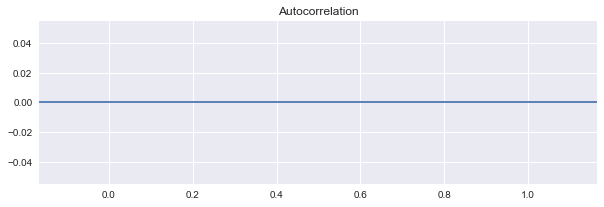

In [13]:
fig = plot_acf(decomp_add.resid, fft=False)
fig.set_figwidth(10)
fig.set_figheight(3)
plt.show()

Biểu đồ ACF của phần dư với toàn bộ giá trị đều gần như bằng 0 ở tất cả các lag có thấy sự uncorrelation của tất cả Errors

---

# Model

## Phân chia tập training-test:
Vì số lượng qua sát là rất là tương đối lớn, đặc biệt và đối với dữ liệu thời tiết
Ta sẽ tiến hàn dự đoán nhiệt độ trong 1 tháng, 1 quý, nửa năm và 1 năm 

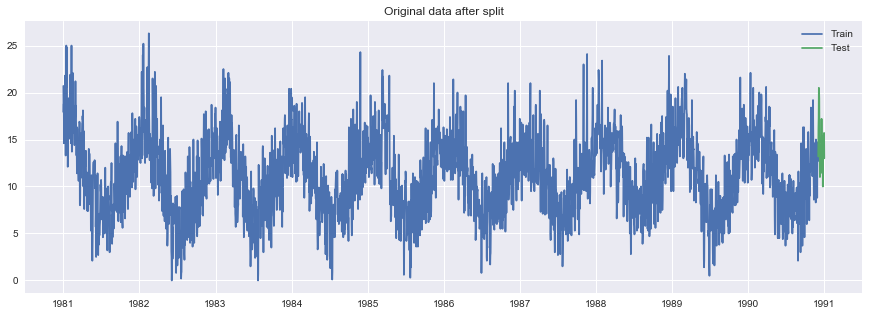

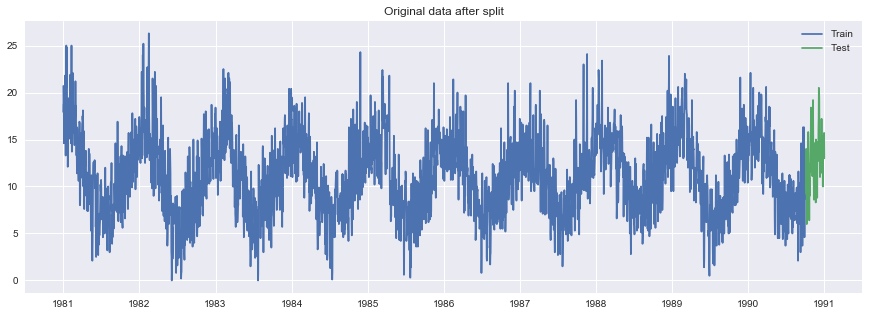

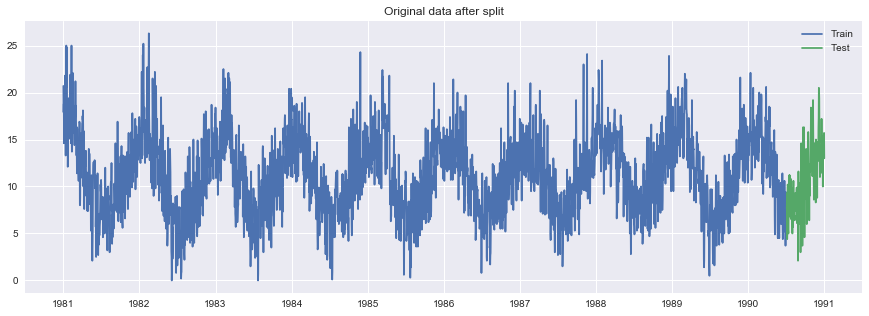

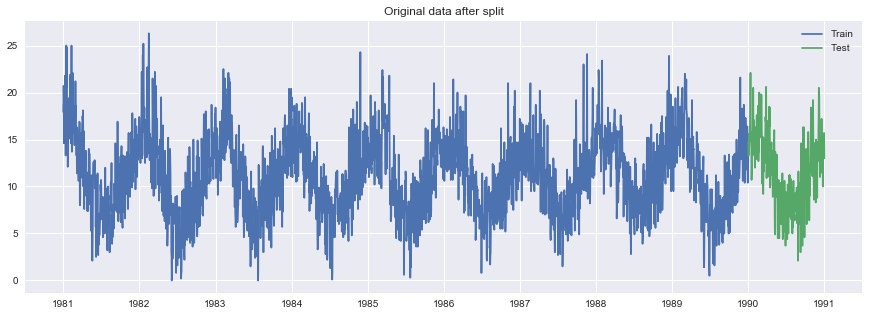

In [14]:
test_size_list = [30, 90, 182, 365]

for test_size in test_size_list:
    train = data[0:len(data)-test_size] 
    test= data[len(data)-test_size:]


    plt.figure(figsize=[15,5])
    plt.grid(True)

    plt.plot(train.index, train.Temp, label = 'Train')
    plt.plot(test.index, test.Temp,  label = 'Test')
    plt.legend(loc = 'best')
    plt.title('Original data after split')
    plt.show()

## 1. Holt-Winters’ additive method

![title](img/HW-component.png)

>- m là period - thời gian cho 1 seanson
>- k = roundown(h-1 mod m) + 1

* PT $ l_{t} $ - mức độ ước lượng tại $t$ cho thấy:
    * thành phần $(y_{t}−s_{t−m}) $; $y_{t}$ được điều chỉnh trừ đi mùa chứ không như các mô hình ES khác. Do đó nó khả năng làm việc tốt với các Time Series có component Season 
    
* PT $ b_{t} $ - Local Trend tại $t$ hoàn toàn lấy từ mô hình thống kê Holt
* PT $ s_{t} $ - Seanson tại $t$ cho thấy liên hệ giữa chỉ số mùa hiện tại $t$ và mùa trước đó $t-m$ 


Để có được mô hình ta cần ước lượng các hệ số: $\alpha, \beta^*, \gamma$ <br>
Trong đó:
>- $\alpha, \beta^* \in [0;1]$ 
>- $\gamma \in [0;1-\alpha]$ 


### Thực hiện chi tiết với dự đoán cho 1 năm (365 ngày)

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

test_size = 365
train = data[0:len(data)-test_size] 
test= data[len(data)-test_size:]
    
HW_pred365 = ExponentialSmoothing(np.asarray(train['Temp']), trend='additive', 
                             damped=False, seasonal='additive',
                             seasonal_periods = 365).fit()

print('### Holt-Winters Additive ###')
print('Ước lượng các hệ số')
alpha = HW_pred365.params['smoothing_level']
beta = HW_pred365.params['smoothing_slope']
gamma = HW_pred365.params['smoothing_seasonal']

print(f'Smoothing Level:    Alpha = {alpha:.4f}')
print(f'Smoothing Slope:    Beta  = {beta:.4f}')
print(f'Smoothing Seasonal: Gamma = {gamma:.4f}')

### Holt-Winters Additive ###
Ước lượng các hệ số
Smoothing Level:    Alpha = 0.3957
Smoothing Slope:    Beta  = 0.0000
Smoothing Seasonal: Gamma = 0.0000


#### Forecast
Kết quả dự đoán như sau:

In [16]:
y_HW_pred365 =  HW_pred365.forecast(steps = test_size)
df_HW_pred365 = pd.DataFrame({'Y_hat':y_HW_pred365,'Y':test['Temp']})
print(df_HW_pred365)

                Y_hat     Y
Date                       
1990-01-01  14.186444  14.8
1990-01-02  13.824937  13.3
1990-01-03  12.872334  15.6
1990-01-04  12.294521  14.5
1990-01-05  12.142520  14.3
...               ...   ...
1990-12-27  10.355783  14.0
1990-12-28  10.137660  13.6
1990-12-29  11.267481  13.5
1990-12-30  13.599556  15.7
1990-12-31  14.396895  13.0

[365 rows x 2 columns]


Plot kết quả dự đoán:

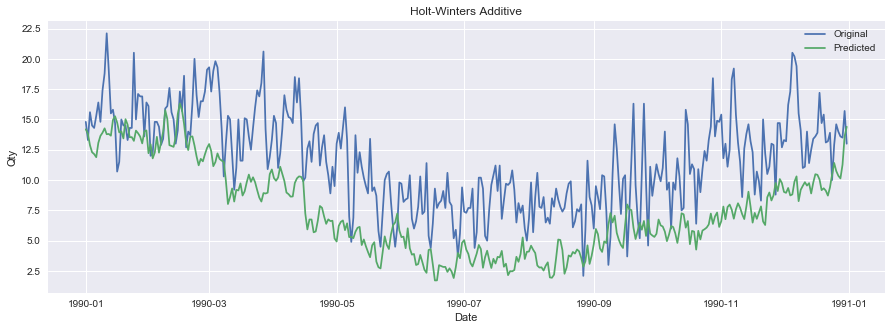

In [17]:
plt.figure(figsize=[15,5])
plt.grid(True)
plt.plot(df_HW_pred365.Y, label='Original')
plt.plot(df_HW_pred365.Y_hat, label='Predicted')

plt.legend(loc='best')
plt.title('Holt-Winters Additive')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

Mô hình Holt-Winter có thể mô hình và forecast đối với Time series có có cả trend và seasonality và việc trực quan hoá dữ liệu ở trên cho thấy điều này

### Thực hiện chi tiết với dự đoán cho 1 tháng (30 ngày)

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

test_size = 30
train = data[0:len(data)-test_size] 
test= data[len(data)-test_size:]
    
HW_pred30 = ExponentialSmoothing(np.asarray(train['Temp']), trend='additive', 
                             damped=False, seasonal='additive',
                             seasonal_periods = 365).fit()

print('### Holt-Winters Additive ###')
print('Ước lượng các hệ số')
alpha = HW_pred30.params['smoothing_level']
beta = HW_pred30.params['smoothing_slope']
gamma = HW_pred30.params['smoothing_seasonal']

print(f'Smoothing Level:    Alpha = {alpha:.4f}')
print(f'Smoothing Slope:    Beta  = {beta:.4f}')
print(f'Smoothing Seasonal: Gamma = {gamma:.4f}')

y_HW_pred30 =  HW_pred30.forecast(steps = test_size)
df_HW_pred30 = pd.DataFrame({'Y_hat':y_HW_pred30,'Y':test['Temp']})

### Holt-Winters Additive ###
Ước lượng các hệ số
Smoothing Level:    Alpha = 0.3948
Smoothing Slope:    Beta  = 0.0001
Smoothing Seasonal: Gamma = 0.0000


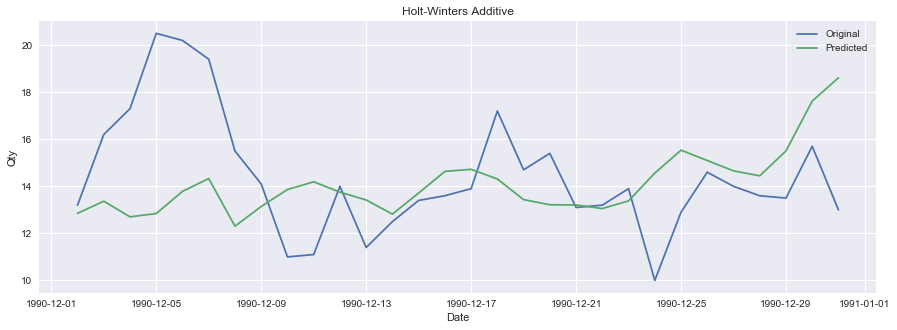

In [19]:
plt.figure(figsize=[15,5])
plt.grid(True)
plt.plot(df_HW_pred30.Y, label='Original')
plt.plot(df_HW_pred30.Y_hat, label='Predicted')

plt.legend(loc='best')
plt.title('Holt-Winters Additive')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

---

### Tiếp theo ta sẽ đánh giá kết quả dự đoán của mô hình

Định nghĩa 3 metrics đánh giá:
>- Mean squared error:
#### <center>$ MSE = \frac{1}{N} \sum \limits _{i=1} ^{N} {( Y_{i} - \hat{Y}_{i} )}^2 $<center>
    
>- Mean absolute error:
#### <center>$ MAE = \frac{1}{N} \sum \limits _{i=1} ^{N} | Y_{i} - \hat{Y}_{i} | $<center>
    
>- Mean absolute percentage error:
#### <center>$ MSE = \frac{100}{N} \sum \limits _{i=1} ^{N} \frac{Y_{i} - \hat{Y}_{i}}{Y_{i}} $<center>

In [20]:
def MSE(Y_true,Y_pred): 
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.square(Y_pred - Y_true))

def MAE(Y_true,Y_pred): 
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.abs(Y_pred - Y_true))


def MAPE(Y_true, Y_pred): 
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.abs(Y_pred - Y_true)/Y_true) * 100

In [21]:
rmse = np.sqrt(MAPE(df_HW_pred30.Y, df_HW_pred30.Y_hat))
mae = MAE(df_HW_pred30.Y, df_HW_pred30.Y_hat)
mape = MAPE(df_HW_pred30.Y, df_HW_pred30.Y_hat)

In [22]:
print(f'Kết quả cho mô hình Holt-Winter forecast nhiệt độ trong 1 tháng:\nRMSE = {rmse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}')

Kết quả cho mô hình Holt-Winter forecast nhiệt độ trong 1 tháng:
RMSE = 3.90, MAE = 2.25, MAPE = 15.23


Với việc forecast cho giá trị nhiệt độ, ta thấy MAE và MAPE có thể sử dụng để diễn giải như sau:

* Nếu dự báo cho 1 tháng = 30 ngày = 30 dự báo:
    * Thì sai số trung bình trên tất cả 30 dự báo vào khoảng 2.25&deg;C
    * Sai số trung bình chiếm khoảng 15.23% nhiệt độ thực tế 


---
### Kết quả khi forecast nhiệt độ trong 1 tháng, 1 quý, nửa năm và 1 năm 

In [23]:
print(f'###  Kết quả cho mô hình Holt-Winter  ###\nVới số lượng dự đoán khác nhau')


for test_size in test_size_list:
    train = data[0:len(data)-test_size] 
    test= data[len(data)-test_size:]
    
    pred1 = ExponentialSmoothing(np.asarray(train['Temp']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 365).fit()
    
    y_pred1 =  pred1.forecast(steps = test_size)
    df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['Temp']})
    
    rmse = np.sqrt(MAPE(df_pred1.Y, df_pred1.Y_hat))
    mae = MAE(df_pred1.Y, df_pred1.Y_hat)
    mape = MAPE(df_pred1.Y, df_pred1.Y_hat)
    print(f'Forecast {test_size:3} ngày: MAE = {mae:.2f}, MAPE = {mape:.2f}')

###  Kết quả cho mô hình Holt-Winter  ###
Với số lượng dự đoán khác nhau
Forecast  30 ngày: MAE = 2.25, MAPE = 15.23
Forecast  90 ngày: MAE = 2.21, MAPE = 17.46
Forecast 182 ngày: MAE = 2.55, MAPE = 25.83
Forecast 365 ngày: MAE = 4.36, MAPE = 38.60


Ta có nhận xét như sau: 
>- Nếu dự đoán cho dưới nửa năm nhiệt độ sai số trung bình rơi vào khoảng dưới 2.5&deg;C. Trong khi nhiệt độ toàn dữ liệu dao động từ 0-26.3&deg;C
>- Nhưng nếu thời gian dự đoán kéo dài đến 1 năm thì sai số dự đoán lên hơn 4&deg;C
>- Tỉ lệ sai số tương ứng tăng dần khi thời gian dự đoán kéo dài ra từ 15.23% đối với 30 ngày và tăng lến 38.6% khi dự đoán nguyên 1 năm

* Mô hình Holt-Winter cho kết quả dự đoán tương đối tốt đối với Time Series có chứa yếu tố Season
* Ở đây ta có dữ liệu thời gian về nhiệt độ trong thời gian khá dài: 3650 quan sát trong 10 năm.
    * Hiệu năng dự đoán trong khoảng thời gian nhất định (<6 tháng) cũng ở mức chấp nhận được đối với 1 dự báo thời tiết và giảm dần độ tin cậy nếu số lượng dự đoán quá nhiều. Tuy nhiên thực tế người ta không dự báo thời tiết trong 1 khoảng thời gian quá dài như vậy